<a href="https://colab.research.google.com/github/sungsujaing/NeuralStyleTransfer_custom/blob/master/StyleTransfer_custom.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## For colab, content and style files need to be uploaded before proceed to the next section

## Import

In [0]:
%tensorflow_version 2.x
from google.colab import files
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import cv2
import os
%matplotlib inline

In [58]:
print(f'tf version: {tf.__version__}')

tf version: 2.0.0


## Load and pre-process images

In [0]:
def load_preprocessing_img(path):
    '''
    preprocess the image array into a normalized 4-D tensor
    '''
    dim_thresh = 512
    img = cv2.imread(path)
    img = img.astype('float32')
    img /= 255.
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    scale = dim_thresh/max(img.shape)
    scaled = (int(img.shape[1]*scale),int(img.shape[0]*scale))
    img = cv2.resize(img,scaled)

    img = tf.convert_to_tensor(img)
    img = img[tf.newaxis,:]
    return img

In [0]:
content = load_preprocessing_img('Goguryeo_tomb_mural.jpg')
style_1 = load_preprocessing_img('starry-night-by-vincent-van-gogh.jpg')
style_2 = load_preprocessing_img('the-weeping-woman-by-pablo-picasso.jpg')

In [61]:
print('content size: {}'.format(content.shape))
print('style_1 size: {}'.format(style_1.shape))
print('style_2 size: {}'.format(style_2.shape))

content size: (1, 422, 512, 3)
style_1 size: (1, 406, 512, 3)
style_2 size: (1, 512, 420, 3)


In [62]:
vgg16_dummy = keras.applications.VGG16(include_top=False, weights='imagenet')
for layer in vgg16_dummy.layers:
    print(layer.name)

input_5
block1_conv1
block1_conv2
block1_pool
block2_conv1
block2_conv2
block2_pool
block3_conv1
block3_conv2
block3_conv3
block3_pool
block4_conv1
block4_conv2
block4_conv3
block4_pool
block5_conv1
block5_conv2
block5_conv3
block5_pool


In [0]:
style_layers = ['block1_conv1','block2_conv1','block3_conv1','block4_conv1','block5_conv1']
content_layers = ['block5_conv2']

In [0]:
def vgg_layers_extractor(layers):
    vgg16 = keras.applications.VGG16(include_top=False, weights='imagenet')
    vgg16.trainable = False

    outputs = [vgg16.get_layer(name).output for name in layers]
    model = keras.Model([vgg16.input], outputs)
    return model

def gram_matrix(input_tensor):
    result = tf.linalg.einsum('bijc,bijd->bcd',input_tensor,input_tensor)
    input_shape = tf.shape(input_tensor)
    num_locations = tf.cast(input_shape[1]*input_shape[2],tf.float32)
    return result/(num_locations)
    
def clip_0_1(image):
    return tf.clip_by_value(image,clip_value_min=0.0,clip_value_max=1.0)

In [0]:
class StyleTransferModel(keras.models.Model):
    def __init__(self,style_layers,content_layers):
        super(StyleTransferModel,self).__init__()
        self.vgg_model = vgg_layers_extractor(style_layers+content_layers)
        self.vgg_model.trainable = False
        self.style_layers = style_layers
        self.content_layers = content_layers
    
    def call(self, img):
        img = keras.applications.vgg16.preprocess_input(img*255.)
        results = self.vgg_model(img)
        style_results = results[:-1]
        style_results = [gram_matrix(style_result) for style_result in style_results]
        content_results = results[-1:]
        
        style_map = {name:val for name,val in zip(self.style_layers,style_results)}
        content_map = {name:val for name,val in zip(self.content_layers,content_results)}

        return {'style':style_map,'content':content_map}

In [66]:
extractor = StyleTransferModel(style_layers,content_layers)
results = extractor(content)

print('<<Style shape>>')
for i in results['style']:
    print(results['style'][i].shape)
print()
print('<<Content shape>>')
for i in results['content']:
    print(results['content'][i].shape)

<<Style shape>>
(1, 64, 64)
(1, 128, 128)
(1, 256, 256)
(1, 512, 512)
(1, 512, 512)

<<Content shape>>
(1, 26, 32, 512)


In [0]:
style_weight = 0.8e-2
content_weight = 1e4
total_variation_weight = 25
optimizer = keras.optimizers.Adam(learning_rate=0.02,beta_1=0.99,epsilon=1e-1)

In [0]:
def custom_loss(results,style_targets,content_targets):
    style_original = results['style']
    content_original = results['content']
    
    style_loss = tf.add_n([tf.reduce_mean(tf.square(style_original[name]-style_targets[name])) for name in style_original])
    style_loss *= style_weight/len(style_layers)
    content_loss = tf.add_n([tf.reduce_mean(tf.square(content_original[name]-content_targets[name])) for name in content_original])
    content_loss *= content_weight/len(content_layers)
    
    loss = style_loss + content_loss
    return loss

@tf.function()
def training(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = custom_loss(outputs,style_targets,content_targets)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss,image)
    optimizer.apply_gradients([(grad,image)])
    image.assign(clip_0_1(image))

def transform(epochs,content_image,save_fig=False):
  print('training begins: ', end='')
  for n in range(epochs+1):
    if n != 0:
      training(content_image)
    if save_fig:
      if n%20 == 0:
        plt.figure(figsize=(7,7))
        plt.imshow(tensor_to_array(content_image))
        plt.title('epoch-{}'.format(n),fontsize=18,fontweight='bold')
        plt.axis('off')
        plt.savefig('style transfer @ epoch-{}.png'.format(n),bbox_inches='tight',dpi=100)
        files.download('style transfer @ epoch-{}.png'.format(n)) 
        plt.close()
    if n%100 == 0:
      print('/'+str(n)+'/')
    if n != epochs:
      print(".", end='')

In [0]:
def tensor_to_array(tensor):
    tensor = tensor * 255
    array = tensor.numpy().astype(int)
    array = array[0]
    return array

In [0]:
content_image = tf.Variable(content)
style_targets = extractor(style_2)['style']
content_targets = extractor(content)['content']

In [71]:
epochs = 1000
transform(epochs,content_image)

training begins: /0/
..................................................................................................../100/
..................................................................................................../200/
..................................................................................................../300/
..................................................................................................../400/
..................................................................................................../500/
..................................................................................................../600/
..................................................................................................../700/
..................................................................................................../800/
..................................................................................................../900/
.........................

In [0]:
def plot_img(img_tensor,title=None):
  plt.figure(figsize=(7,7))
  plt.imshow(tensor_to_array(img_tensor))
  if title:
    plt.title(title,fontsize=18,fontweight='bold')
  plt.axis('off')
  plt.show()

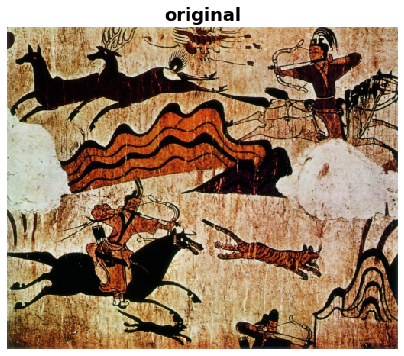

In [73]:
plot_img(content,'original')

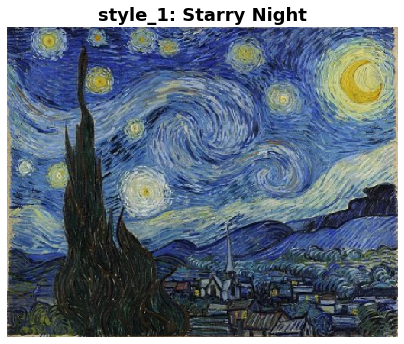

In [82]:
plot_img(style_1,'style_1: Starry Night')

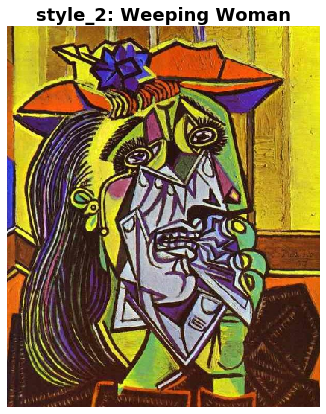

In [83]:
plot_img(style_2,'style_2: Weeping Woman')

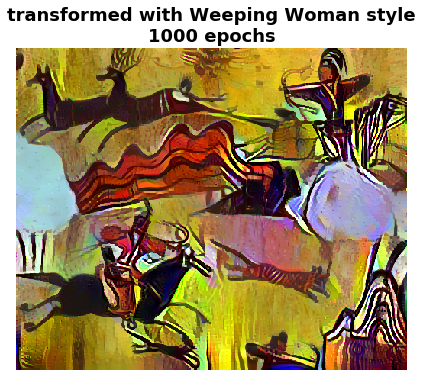

In [74]:
plot_img(content_image,'transformed with Weeping Woman style\n1000 epochs')

## Mixing two styles on one content

In [0]:
def custom_loss_two_styles(results,style_targets_1,style_targets_2,content_targets):
    style_original = results['style']
    content_original = results['content']

    cut = 2
    
    style_loss_1 = tf.add_n([tf.reduce_mean(tf.square(style_original[name]-style_targets_1[name])) for name in list(style_targets_1.keys())[:cut]])
    style_loss_1 *= style_weight/len(style_layers)*2

    style_loss_2 = tf.add_n([tf.reduce_mean(tf.square(style_original[name]-style_targets_2[name])) for name in list(style_targets_1.keys())[cut:]])
    style_loss_2 *= style_weight/len(style_layers)*3
    
    content_loss = tf.add_n([tf.reduce_mean(tf.square(content_original[name]-content_targets[name])) for name in content_original])
    content_loss *= content_weight/len(content_layers)
    
    loss = style_loss_1 + style_loss_2 + content_loss
    return loss

optimizer = keras.optimizers.Adam(learning_rate=0.02,beta_1=0.99,epsilon=1e-1)
@tf.function()
def training_two_styles(image):
    with tf.GradientTape() as tape:
        outputs = extractor(image)
        loss = custom_loss_two_styles(outputs,style_targets_1,style_targets_2,content_targets)
        loss += total_variation_weight*tf.image.total_variation(image)

    grad = tape.gradient(loss,image)
    optimizer.apply_gradients([(grad,image)])
    image.assign(clip_0_1(image))

def transform_two_styles(epochs,content_image,save_fig=False):
  print('training begins: ', end='')
  for n in range(epochs+1):
    if n != 0:
      training_two_styles(content_image)
    if save_fig:
      if n%20 == 0:
        plt.figure(figsize=(7,7))
        plt.imshow(tensor_to_array(content_image))
        plt.title('epoch-{}'.format(n),fontsize=18,fontweight='bold')
        plt.axis('off')
        plt.savefig('style transfer @ epoch-{}.png'.format(n),bbox_inches='tight',dpi=100)
        files.download('style transfer @ epoch-{}.png'.format(n)) 
        plt.close()
    if n%100 == 0:
      print('/'+str(n)+'/')
    if n != epochs:
      print(".", end='')

In [0]:
content_image = tf.Variable(content)
style_targets_1 = extractor(style_1)['style']
style_targets_2 = extractor(style_2)['style']
content_targets = extractor(content)['content']

In [77]:
epochs = 1000
transform_two_styles(epochs,content_image)

training begins: /0/
..................................................................................................../100/
..................................................................................................../200/
..................................................................................................../300/
..................................................................................................../400/
..................................................................................................../500/
..................................................................................................../600/
..................................................................................................../700/
..................................................................................................../800/
..................................................................................................../900/
.........................

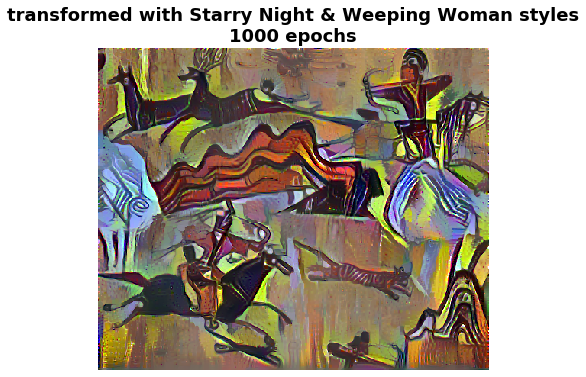

In [81]:
plot_img(content_image,'transformed with Starry Night & Weeping Woman styles\n1000 epochs')